https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_deep_learning_basics/deep_learning_basics.ipynb

In [4]:
! pip install pandas
! pip install seaborn

pip install opencv-python

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

2.7.0


###### 회귀(Regression)와 분류(Classification)
- 회귀 모델. 연속적인 값의 라벨을 예측.
    예: 온도,몸무게
- 분류 모델. 불연속적 값의 라벨 예측.
    예: 날씨(추운가?더운가?), 암의 유무

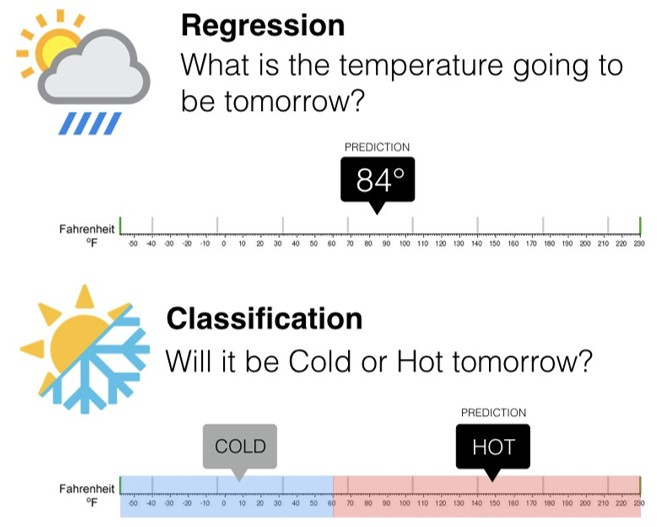

## Part 1: 보스턴시 주택 가격 예측 (순방향 신경망)
(Boston Housing Price Prediction with Feed Forward Neural Networks)

- Let's start with using a fully-connected neural network to do predict housing prices.

- we get 506 rows of data, with 13 features in each. 
- Our task is to build a regression model that takes these 13 features as input and output a single value prediction of the "median value of owner-occupied homes (in $1000)."

### 1.훈련 셋 (train_features , train_labels) 과 테스트 셋 (test_features, test_labels) 분리하여 데이터 불러오기
- The train_images and train_labels arrays are the training set—the data the model uses to learn.
- The model is tested against the test set, the test_images, and test_labels arrays.

In [15]:
# 데이터 불러오기 (train, test 분리)
(train_features, train_labels), (test_features, test_labels) = keras.datasets.boston_housing.load_data()

In [18]:
# get per-feature statistics (mean, std) from the training set to normalize by

train_mean = np.mean(train_features, axis=0)
train_std = np.std(train_features, axis=0)
train_features = (train_features - train_mean) / train_std # 표준화 작업. (학습을 편리하게 하기 위함.)

In [19]:
train_features

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

표준화 하는 이유 ? (standardization)
- 입력을 Standardization하면 학습을 더 빨리하고 지역 최적의 상태에 빠지게 될 가능성을 줄이는 다양한 실용적인 이유가 있습니다.
- 또한, 표준화 된 입력을 통해 Gradient Descent 및 Bayesian estimation을 보다 편리하게 수행 할 수 있습니다.

정규화 하는 이유 ? (normalization)
- Unnormalized된 상태에서는 Learning Rate을 매우 작게 설정해야 정상적을 학습이 된다.
- 좀 더 Gradient Descent Algorithm으로 쉽게 그리고 빠르게 최적화 지점을 찾게 된다.

### 2. 모델 생성하기

- (1) keras. Sequential 을 이용하여 몇개의 층을 쌓기.
- (First we stack a few layers together using "keras.Sequential")
- (2) 그 다음 손실함수, 옵티마이저, 훈련과정 모니터하기 위한 평가지표(metrics) 를 설정해라.
- (Next we configure the loss function, optimizer, and metrics to monitor.)

- Loss function - measures how accurate the model is during training, we want to minimize this with the optimizer.
- Optimizer - how the model is updated based on the data it sees and its loss function.
- Metrics - used to monitor the training and testing steps.

In [3]:
# Dense 층 2개, 활성화 relu 함수, 옵티마이저 Adam 함수,  
def build_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(train_features[0])]),
        Dense(1)
    ])

    model.compile(optimizer=tf.train.AdamOptimizer(), 
                  loss='mse',
                  metrics=['mae', 'mse']) # optimizer (최적화) : 실제값 - 예측 결과 최소화  
    return model

In [9]:
len(train_features[0])

13

### 3. 모델 훈련하기

신경망 모델을 훈련하는 것은 다음을 필요로 한다. 

- 1. 모델에 훈련 데이터를 입력함, train_features 와 train_labels 
- 2. 모델은 피처와 레이블을 학습함. 
- 3. 우리는 모델에게 test 셋에 대한 예측을 만들것을 요청, 예를 들어 "test_features" 
- 4. 우리는 예측값이 test_labels 과 match가 되는지 확인함. 

(We ask the model to make predictions about a test set—in this example, the test_features array. 
We verify that the predictions match the labels from the test_labels array.)

- 훈련을 시작하려면 모델을 호출, model.fit
- (To start training, call the model.fit method—the model is "fit" to the training data:)

In [4]:
# this helps makes our output less verbose but still shows progress
# 출력층에서 진행되는 것을 보여줌, (손실 보여주는 것 도와줌)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('') # 에포크가 100
        print('.', end='')

- verbose : 학습의 진행 상황을 보여줄 것인지 지정을 하는데 verbose를 1로 세팅하면 학습이 되는 모습을 볼 수 있다.
- patience : 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가

In [6]:
model = build_model() ###### 에러 발생 지점 #######

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50) # validation set 의 loss 를 monitoring

history = model.fit(train_features, train_labels, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()]) # 에포크 횟수 만큼 . 찍기 / 검증 셋 10% 사용. 

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch # 히스토리 기능 사용. 매 에포크 횟수 

# show RMSE measure to compare to Kaggle leaderboard on https://www.kaggle.com/c/boston-housing/leaderboard
rmse_final = np.sqrt(float(hist['val_mean_squared_error'].tail(1)))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

C:\Users\KIOST\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................
Final Root Mean Square Error on validation set: 2.366


####  *에러 발생 (module 'tensorflow._api.v2.train' has no attribute 'AdamOptimizer')*
- 문제점 : 많은 예제들이 tensorflow 1.x 버전을 기준으로 작성되어 tensorflow 2.0 최신버전으로 설치되어 에러 발생.
    - 해결방안 : 1.x 버전을 import 할 수 있도록 설정해준다.

In [5]:
# 추가한 코드
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


=====================================1월4일=================================================

In [12]:
hist # 에포크에 따른 평가지표들 확인/ epoch 횟수가 늘어나면서 loss가 줄어 듦. 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,613.297115,22.799318,613.297058,511.378083,21.598824,511.378082,0
1,603.474289,22.584318,603.474243,503.412270,21.406164,503.412262,1
2,594.139417,22.380733,594.139404,495.919434,21.221872,495.919434,2
3,585.464622,22.180132,585.464600,488.653548,21.035177,488.653534,3
4,577.139073,21.987061,577.139099,481.685364,20.851824,481.685364,4
...,...,...,...,...,...,...,...
670,6.653207,1.826838,6.653207,5.555194,1.944821,5.555194,670
671,6.665169,1.830348,6.665170,5.637852,1.968115,5.637852,671
672,6.642100,1.828657,6.642100,5.772804,2.001435,5.772804,672
673,6.625412,1.824465,6.625413,5.655488,1.968955,5.655488,673


- Next, compare how the model performs on the test dataset:
- 그런 다음 테스트 데이터 세트에서 모델의 성능을 비교합니다.

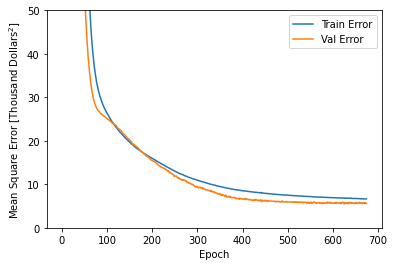

In [7]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,50])

plot_history()

Compare the RMSE measure you get to the Kaggle leaderboard. An RMSE of 2.651 puts us in 5th place.
- RMSE는 2.651 

#### ***Discussion ***

In [9]:
test_features_norm = (test_features - train_mean) / train_std # 이 부분 이해 안 감 .. ! (표준화를 더 해주는 이유..?)
mse, _, _ = model.evaluate(test_features_norm, test_labels)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

Root Mean Square Error on test set: 4.288


=========================1월 9일============================================

## Part 2: 컨볼루션 신경망을 이용한 MNIST 꿈의 분류
- Classification of MNIST Dreams with Convolutional Neural Networks
- 다음으로, 데이터 세트 외부에서 고해상도 필기 숫자로 분류기를 테스트하는 TWIT로 MNIST 데이터 셋의 필기 숫자 이미지를 분류하는 CNN(Convolutional Neural Network)으로 분류기를 구축해보자
- (Next, let's build a convolutional neural network (CNN) classifier to classify images of handwritten digits in the MNIST dataset with a twist where we test our classifier on high-resolution hand-written digits from outside the dataset.)

In [10]:
# Set common constants
this_repo_url = 'https://github.com/lexfridman/mit-deep-learning/raw/master/'
this_tutorial_url = this_repo_url + 'tutorial_deep_learning_basics'

- MNIST 데이터 셋에는 손으로 쓴 28 * 28 픽셀의 흑백 숫자 이미지가 있다. 
The MNIST dataset containss 70,000 grayscale images of handwritten digits at a resolution of 28 by 28 pixels. 
- 우리가 할 작업은 이러한 이미지 중 하나를 입력으로 가져와서 가장 가능성이 높은 숫자를 예측하는 것.
-The task is to take one of these images as input and predict the most likely digit contained in the image (along with a relative confidence in this prediction):

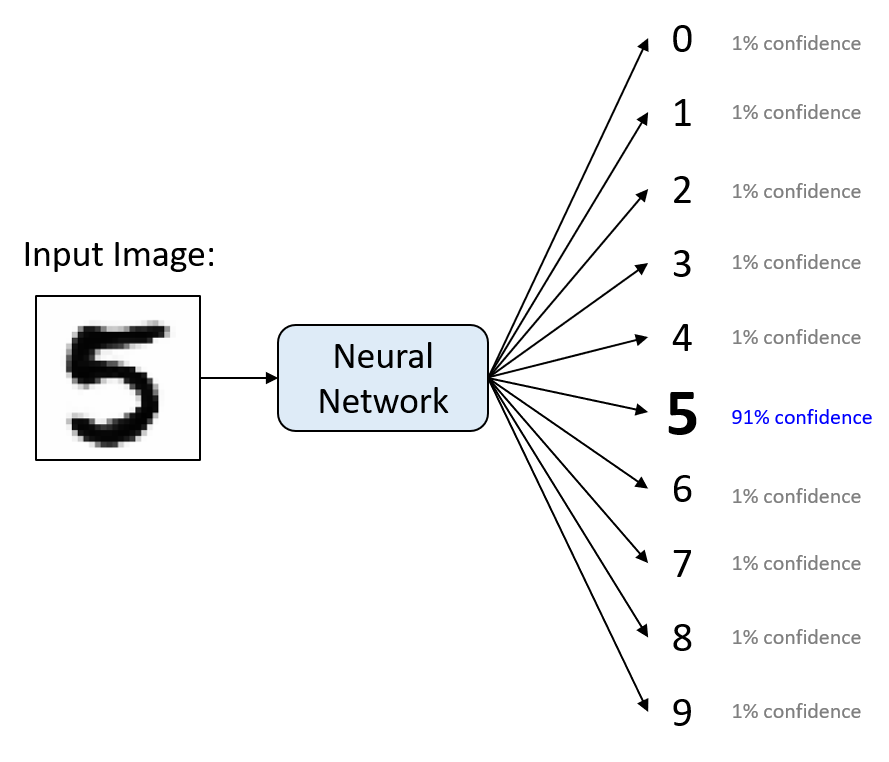

- 이제 데이터 셋을 불러오자, 
- 이미지는 28x28 NumPy 배열이며 픽셀 값은 0에서 255 사이입니다. 레이블은 0에서 9 사이의 정수의 배열입니다.
- Now, we load the dataset. The images are 28x28 NumPy arrays, with pixel values ranging between 0 and 255. The labels are an array of integers, ranging from 0 to 9.

In [11]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# 단일 채널임을 지정하기 위해 이미지 모양을 바꾼다.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

#### reshape를 하는 이유?
- 데이터를 Keras에 맞게 변환(Reshape)해주는 과정입니다..MNIST에서 이게 왜필요하지?라는 생각이 들긴하는데,
- MNIST는 흑백이라서 어차피 채널이 1개뿐이지만, 만약 컬러이미지를 이용하여 트레이닝한다고 하면,
- 컬러이미지는 RGB 각 1채널씩 총 3개의 채널로 구성되어있기 때문에 해줘야합니다.

단, Tensorflow를 사용할 경우엔 (width, height, channel)로 표현됩니다.

- We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the training set and the testing set are preprocessed in the same way:`
- 우리는 신경망 모델에 공급하기 전에 이러한 값을 0-1 범위로 확장한다. 이를 위해 값을 255로 나눕니다. 훈련 세트와 테스트 세트를 동일한 방식으로 사전 처리하는 것이 중요합니다.

In [12]:
def preprocess_images(imgs): # 단일 영상과 다중 영상 모두에 대해 작동해야 합니다.
    sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
    assert sample_img.shape in [(28, 28, 1), (28, 28)], sample_img.shape # 이미지가 28x28이고 단일 채널(스케일)인지 확인합니다.
    return imgs / 255.0

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

- 훈련 세트에서 처음 5개의 영상을 표시하고 각 영상 아래에 클래스 이름을 표시합니다. 
- 데이터가 올바른 형식이고 네트워크를 구축하고 훈련할 준비가 되었는지 확인합니다.

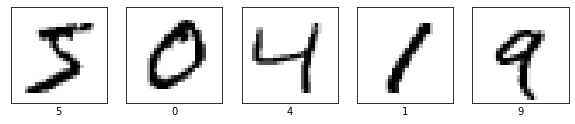

In [13]:
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

============================================1월 10일 ===================================================

### 모델 설계

- 신경망을 구축하려면 모델의 레이어를 구성한 다음 모델을 컴파일해야 합니다. 많은 경우에 이것은 단순히 층을 쌓는 것으로 축소될 수 있다.

- Building the neural network requires configuring the layers of the model, then compiling the model. In many cases, this can be reduced to simply stacking together layers:

In [14]:
model = keras.Sequential()
# 3*3 크기의 컨볼루션 필터 32개 사용. 
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# 3*3 크기의 컨볼루션 필터 64개 사용. 
model.add(Conv2D(64, (3, 3), activation='relu'))
# 풀링을 통해 최상의 features 선택. 
model.add(MaxPooling2D(pool_size=(2, 2)))
# 수렴을 향상시키기 위해 무작위로 뉴런을 껐다 킴. 
model.add(Dropout(0.25))
# 너무 많은 차원이 있기 때문에 평평, 우리는 분류의 출력만 필요함. 
model.add(Flatten())
# fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
# one more dropout
model.add(Dropout(0.5))
# output a softmax to squash the matrix into output probabilities
model.add(Dense(10, activation='softmax'))

=======================================1월 11일 ===============================================================

In [15]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(train_images, train_labels, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 43s 723us/sample - loss: 0.1919 - acc: 0.9420
Epoch 2/5
60000/60000 [==============================] - 45s 745us/sample - loss: 0.0795 - acc: 0.9765
Epoch 3/5
60000/60000 [==============================] - 45s 751us/sample - loss: 0.0621 - acc: 0.9814
Epoch 4/5
60000/60000 [==============================] - 45s 750us/sample - loss: 0.0482 - acc: 0.9851
Epoch 5/5
60000/60000 [==============================] - 45s 751us/sample - loss: 0.0412 - acc: 0.9868


In [ ]:
print(test_images.shape)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

In [ ]:
mnist_dream_path = 'images/mnist_dream.mp4'
mnist_prediction_path = 'images/mnist_dream_predicted.mp4'

# download the video if running in Colab
if not os.path.isfile(mnist_dream_path): 
    print('downloading the sample video...')
    vid_url = this_tutorial_url + '/' + mnist_dream_path
    
    mnist_dream_path = urllib.request.urlretrieve(vid_url)[0]
                                                                                                  
def cv2_imshow(img):
    ret = cv2.imencode('.png', img)[1].tobytes() 
    img_ip = IPython.display.Image(data=ret)
    IPython.display.display(img_ip)

cap = cv2.VideoCapture(mnist_dream_path) 
vw = None
frame = -1 # counter for debugging (mostly), 0-indexed

# go through all the frames and run our classifier on the high res MNIST images as they morph from number to number
while True: # should 481 frames
    frame += 1
    ret, img = cap.read()
    if not ret: break
               
    assert img.shape[0] == img.shape[1] # should be a square
    if img.shape[0] != 720:
        img = cv2.resize(img, (720, 720))
       
    #preprocess the image for prediction
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_proc = cv2.resize(img_proc, (28, 28))
    img_proc = preprocess_images(img_proc)
    img_proc = 1 - img_proc # inverse since training dataset is white text with black background

    net_in = np.expand_dims(img_proc, axis=0) # expand dimension to specify batch size of 1
    net_in = np.expand_dims(net_in, axis=3) # expand dimension to specify number of channels
    
    preds = model.predict(net_in)[0]
    guess = np.argmax(preds)
    perc = np.rint(preds * 100).astype(int)
    
    img = 255 - img
    pad_color = 0
    img = np.pad(img, ((0,0), (0,1280-720), (0,0)), mode='constant', constant_values=(pad_color))  
    
    line_type = cv2.LINE_AA
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.3        
    thickness = 2
    x, y = 740, 60
    color = (255, 255, 255)
    
    text = "Neural Network Output:"
    cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
    
    text = "Input:"
    cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)   
        
    y = 130
    for i, p in enumerate(perc):
        if i == guess: color = (255, 218, 158)
        else: color = (100, 100, 100)
            
        rect_width = 0
        if p > 0: rect_width = int(p * 3.3)
        
        rect_start = 180
        cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)

        text = '{}: {:>3}%'.format(i, int(p))
        cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
        y += 60
    
    # if you don't want to save the output as a video, set this to False
    save_video = True
    
    if save_video:
        if vw is None:
            codec = cv2.VideoWriter_fourcc(*'DIVX')
            vid_width_height = img.shape[1], img.shape[0]
            vw = cv2.VideoWriter(mnist_prediction_path, codec, 30, vid_width_height)
        # 15 fps above doesn't work robustly so we right frame twice at 30 fps
        vw.write(img)
        vw.write(img)
    
    # scale down image for display
    img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    cv2_imshow(img_disp)
    IPython.display.clear_output(wait=True)
        
cap.release()
if vw is not None:
    vw.release()